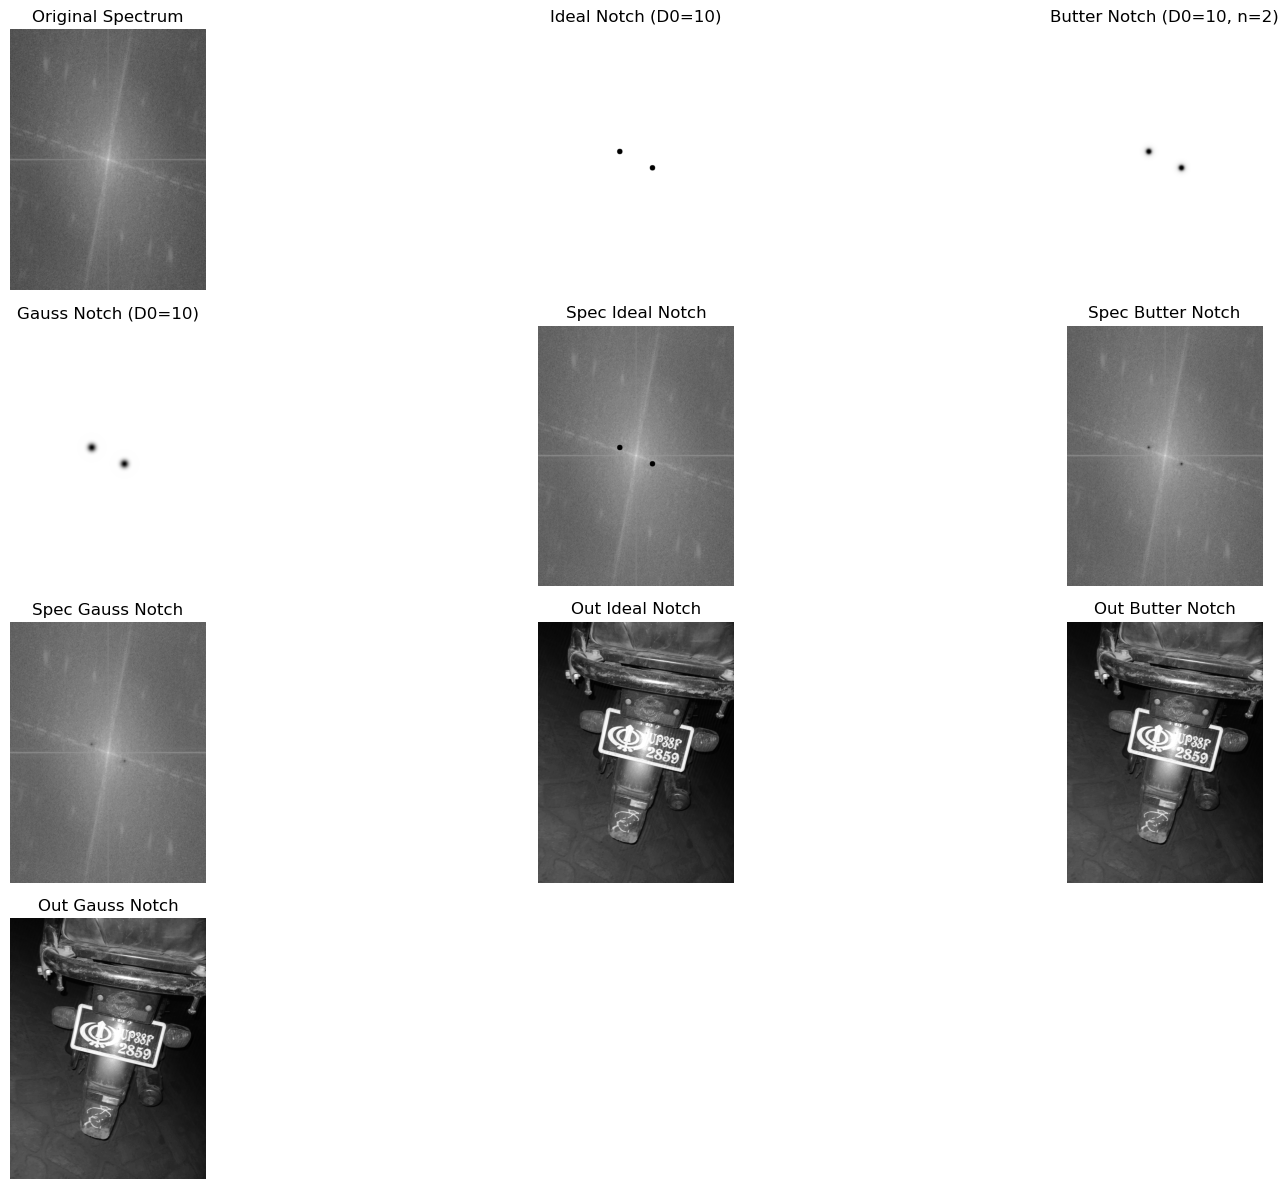

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMG_PATH = r"E:\Indian_Number_Plates\Sample_Images\Datacluster_number_plates (55).jpg"

def show_grid(titles, imgs, max_cols=4, figsize=(16,12)):
    n = len(imgs); cols = min(max_cols, n); rows = (n+cols-1)//cols
    plt.figure(figsize=figsize)
    for i,(t,img) in enumerate(zip(titles, imgs), 1):
        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap='gray'); plt.title(t); plt.axis('off')
    plt.tight_layout(); plt.show()

def load_gray(path):
    bgr = cv2.imread(path); 
    if bgr is None: raise FileNotFoundError(path)
    h,w = bgr.shape[:2]
    scale = min(1.0, 720.0/min(h,w))
    bgr = cv2.resize(bgr, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

def dft2(img): return np.fft.fftshift(np.fft.fft2(img.astype(np.float32)))
def idft2(F):  return np.clip(np.real(np.fft.ifft2(np.fft.ifftshift(F))),0,255).astype(np.uint8)
def spectrum(F):
    M = np.log1p(np.abs(F)); M = 255*(M - M.min())/(M.max()-M.min()+1e-12); return M.astype(np.uint8)

def notch_mask_ideal(shape, centers, D0):
    R,C = shape
    U = np.arange(R) - R//2
    V = np.arange(C) - C//2
    Vv, Uu = np.meshgrid(V, U)
    H = np.ones(shape, np.float32)
    for (uk, vk) in centers:
        Dk = np.sqrt((Uu-uk)**2 + (Vv-vk)**2)
        Dk_sym = np.sqrt((Uu+uk)**2 + (Vv+vk)**2)  # conjugate
        H[Dk <= D0] = 0.0
        H[Dk_sym <= D0] = 0.0
    return H

def notch_mask_butter(shape, centers, D0, n=2):
    R,C = shape
    U = np.arange(R) - R//2
    V = np.arange(C) - C//2
    Vv, Uu = np.meshgrid(V, U)
    H = np.ones(shape, np.float32)
    eps = 1e-12
    for (uk, vk) in centers:
        Dk = np.sqrt((Uu-uk)**2 + (Vv-vk)**2) + eps
        Dk_sym = np.sqrt((Uu+uk)**2 + (Vv+vk)**2) + eps
        H *= 1.0 / (1.0 + (D0/Dk)**(2*n))
        H *= 1.0 / (1.0 + (D0/Dk_sym)**(2*n))
    return H

def notch_mask_gauss(shape, centers, D0):
    R,C = shape
    U = np.arange(R) - R//2
    V = np.arange(C) - C//2
    Vv, Uu = np.meshgrid(V, U)
    H = np.ones(shape, np.float32)
    for (uk, vk) in centers:
        Dk = ((Uu-uk)**2 + (Vv-vk)**2)
        Dk_sym = ((Uu+uk)**2 + (Vv+vk)**2)
        H *= (1 - np.exp(-Dk/(2*(D0**2)+1e-12)))
        H *= (1 - np.exp(-Dk_sym/(2*(D0**2)+1e-12)))
    return H

# Simple “optimize” helpers: pick strongest spectral peaks away from DC
def find_notch_centers(F, topk=2, min_radius=20):
    # magnitude with DC suppressed
    Mag = np.abs(F)
    r,c = Mag.shape
    Mag[r//2-5:r//2+5, c//2-5:c//2+5] = 0  # zero out DC area
    # find top-k peaks
    flat_idx = np.argpartition(Mag.ravel(), -topk)[-topk:]
    coords = np.array(np.unravel_index(flat_idx, Mag.shape)).T
    # keep those beyond a minimum radius
    centers = []
    for y,x in coords:
        if np.hypot(y - r//2, x - c//2) >= min_radius:
            centers.append((y - r//2, x - c//2))  # shift to centered coords
    return centers

# Load and compute DFT
gray = load_gray(IMG_PATH)
F = dft2(gray)
spec0 = spectrum(F)

# Auto-select notch centers (you can replace with manual ones)
centers = find_notch_centers(F, topk=2, min_radius=25)
if len(centers) == 0:
    centers = [(30, 60)]  # fallback example

D0 = 10; order = 2

H_i = notch_mask_ideal(gray.shape, centers, D0)
H_b = notch_mask_butter(gray.shape, centers, D0, n=order)
H_g = notch_mask_gauss(gray.shape, centers, D0)

out_i = idft2(F*H_i); spec_i = spectrum(F*H_i)
out_b = idft2(F*H_b); spec_b = spectrum(F*H_b)
out_g = idft2(F*H_g); spec_g = spectrum(F*H_g)

titles = [
    "Original Spectrum", f"Ideal Notch (D0={D0})", f"Butter Notch (D0={D0}, n={order})", f"Gauss Notch (D0={D0})",
    "Spec Ideal Notch", "Spec Butter Notch", "Spec Gauss Notch",
    "Out Ideal Notch", "Out Butter Notch", "Out Gauss Notch"
]
imgs = [spec0, H_i*255, (H_b*255).astype(np.uint8), (H_g*255).astype(np.uint8),
        spec_i, spec_b, spec_g, out_i, out_b, out_g]
show_grid(titles, imgs, max_cols=3, figsize=(16,12))

# “Optimized” notch filters are simply the above masks with centers chosen by find_notch_centers;
# tweak topk, min_radius, D0, and order to remove periodic patterns without degrading details.


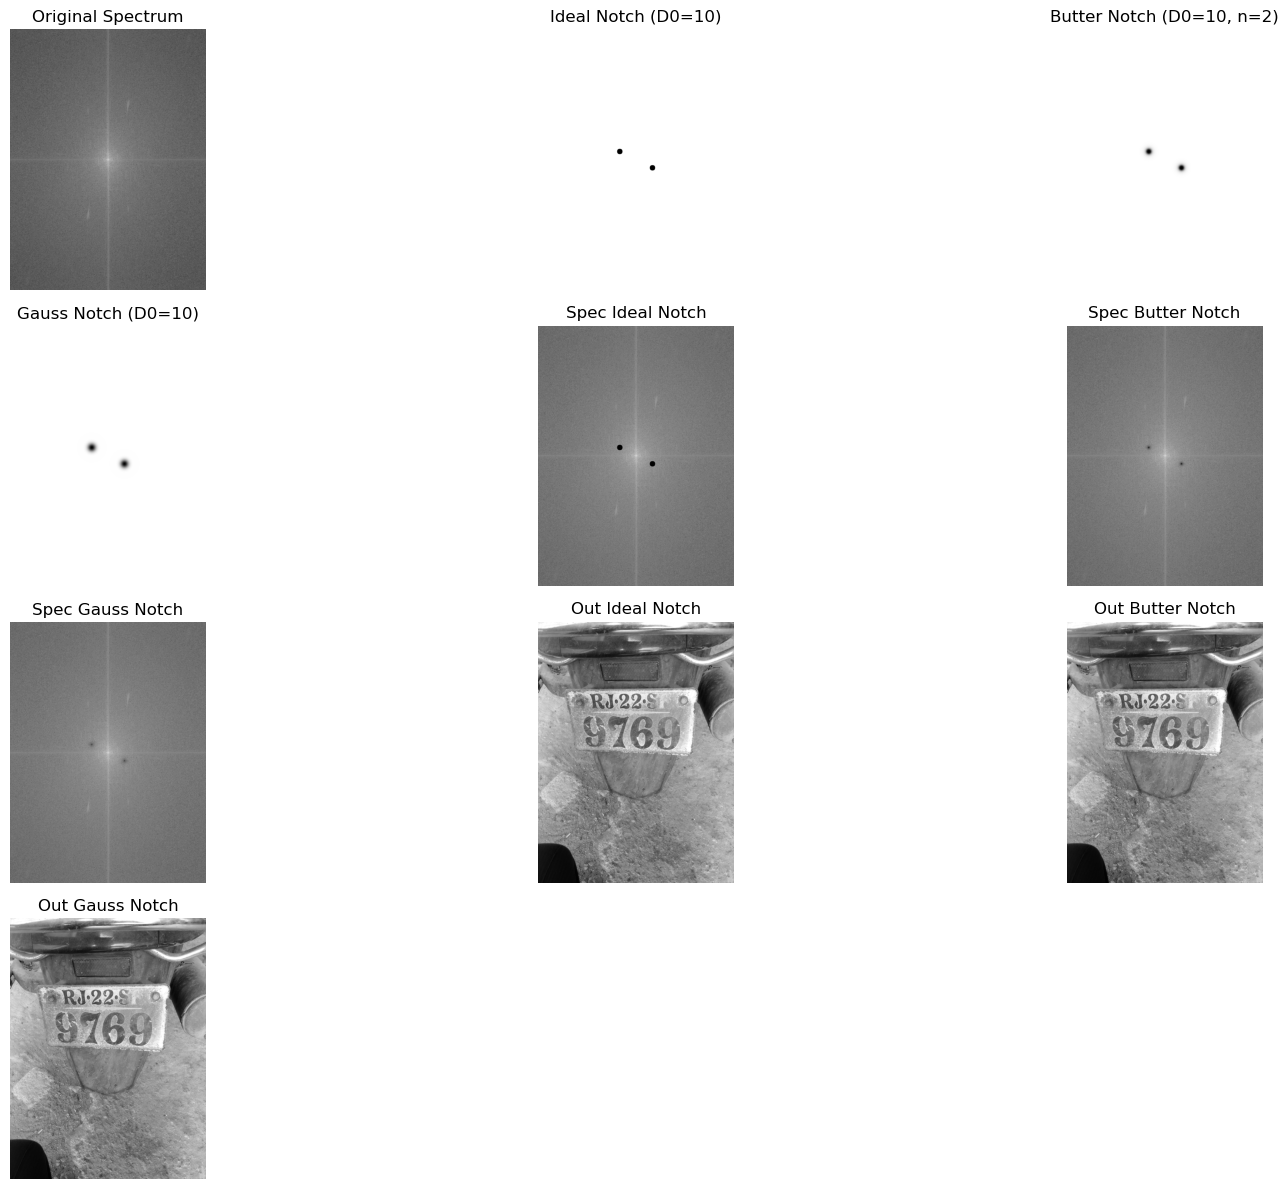

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMG_PATH = r"E:\Indian_Number_Plates\Sample_Images\Datacluster_number_plates (84).jpg"

def show_grid(titles, imgs, max_cols=4, figsize=(16,12)):
    n = len(imgs); cols = min(max_cols, n); rows = (n+cols-1)//cols
    plt.figure(figsize=figsize)
    for i,(t,img) in enumerate(zip(titles, imgs), 1):
        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap='gray'); plt.title(t); plt.axis('off')
    plt.tight_layout(); plt.show()

def load_gray(path):
    bgr = cv2.imread(path); 
    if bgr is None: raise FileNotFoundError(path)
    h,w = bgr.shape[:2]
    scale = min(1.0, 720.0/min(h,w))
    bgr = cv2.resize(bgr, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

def dft2(img): return np.fft.fftshift(np.fft.fft2(img.astype(np.float32)))
def idft2(F):  return np.clip(np.real(np.fft.ifft2(np.fft.ifftshift(F))),0,255).astype(np.uint8)
def spectrum(F):
    M = np.log1p(np.abs(F)); M = 255*(M - M.min())/(M.max()-M.min()+1e-12); return M.astype(np.uint8)

def notch_mask_ideal(shape, centers, D0):
    R,C = shape
    U = np.arange(R) - R//2
    V = np.arange(C) - C//2
    Vv, Uu = np.meshgrid(V, U)
    H = np.ones(shape, np.float32)
    for (uk, vk) in centers:
        Dk = np.sqrt((Uu-uk)**2 + (Vv-vk)**2)
        Dk_sym = np.sqrt((Uu+uk)**2 + (Vv+vk)**2)  # conjugate
        H[Dk <= D0] = 0.0
        H[Dk_sym <= D0] = 0.0
    return H

def notch_mask_butter(shape, centers, D0, n=2):
    R,C = shape
    U = np.arange(R) - R//2
    V = np.arange(C) - C//2
    Vv, Uu = np.meshgrid(V, U)
    H = np.ones(shape, np.float32)
    eps = 1e-12
    for (uk, vk) in centers:
        Dk = np.sqrt((Uu-uk)**2 + (Vv-vk)**2) + eps
        Dk_sym = np.sqrt((Uu+uk)**2 + (Vv+vk)**2) + eps
        H *= 1.0 / (1.0 + (D0/Dk)**(2*n))
        H *= 1.0 / (1.0 + (D0/Dk_sym)**(2*n))
    return H

def notch_mask_gauss(shape, centers, D0):
    R,C = shape
    U = np.arange(R) - R//2
    V = np.arange(C) - C//2
    Vv, Uu = np.meshgrid(V, U)
    H = np.ones(shape, np.float32)
    for (uk, vk) in centers:
        Dk = ((Uu-uk)**2 + (Vv-vk)**2)
        Dk_sym = ((Uu+uk)**2 + (Vv+vk)**2)
        H *= (1 - np.exp(-Dk/(2*(D0**2)+1e-12)))
        H *= (1 - np.exp(-Dk_sym/(2*(D0**2)+1e-12)))
    return H

# Simple “optimize” helpers: pick strongest spectral peaks away from DC
def find_notch_centers(F, topk=2, min_radius=20):
    # magnitude with DC suppressed
    Mag = np.abs(F)
    r,c = Mag.shape
    Mag[r//2-5:r//2+5, c//2-5:c//2+5] = 0  # zero out DC area
    # find top-k peaks
    flat_idx = np.argpartition(Mag.ravel(), -topk)[-topk:]
    coords = np.array(np.unravel_index(flat_idx, Mag.shape)).T
    # keep those beyond a minimum radius
    centers = []
    for y,x in coords:
        if np.hypot(y - r//2, x - c//2) >= min_radius:
            centers.append((y - r//2, x - c//2))  # shift to centered coords
    return centers

# Load and compute DFT
gray = load_gray(IMG_PATH)
F = dft2(gray)
spec0 = spectrum(F)

# Auto-select notch centers (you can replace with manual ones)
centers = find_notch_centers(F, topk=2, min_radius=25)
if len(centers) == 0:
    centers = [(30, 60)]  # fallback example

D0 = 10; order = 2

H_i = notch_mask_ideal(gray.shape, centers, D0)
H_b = notch_mask_butter(gray.shape, centers, D0, n=order)
H_g = notch_mask_gauss(gray.shape, centers, D0)

out_i = idft2(F*H_i); spec_i = spectrum(F*H_i)
out_b = idft2(F*H_b); spec_b = spectrum(F*H_b)
out_g = idft2(F*H_g); spec_g = spectrum(F*H_g)

titles = [
    "Original Spectrum", f"Ideal Notch (D0={D0})", f"Butter Notch (D0={D0}, n={order})", f"Gauss Notch (D0={D0})",
    "Spec Ideal Notch", "Spec Butter Notch", "Spec Gauss Notch",
    "Out Ideal Notch", "Out Butter Notch", "Out Gauss Notch"
]
imgs = [spec0, H_i*255, (H_b*255).astype(np.uint8), (H_g*255).astype(np.uint8),
        spec_i, spec_b, spec_g, out_i, out_b, out_g]
show_grid(titles, imgs, max_cols=3, figsize=(16,12))

# “Optimized” notch filters are simply the above masks with centers chosen by find_notch_centers;
# tweak topk, min_radius, D0, and order to remove periodic patterns without degrading details.
